In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
reload(database)
db = database.thomas_18_db

In [3]:
figdir='/mnt/home/szheng/ceph/place_variability/fig/paper/figure_block_reuse'
figdir= misc.get_or_create_subdir(figdir)

In [4]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

In [5]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)
import get_thomas_cell_metrics as gtcm
reload(gtcm)
import unimodal_nmf as unmf

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
%%time
reload(fmtas)
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=False,bin_size=0.022,gauss_width=1,save_fn_one='fr_map_mask_True_smallbin.p',save_fn_all='fr_map_mask_True_smallbin.p')
# fr_map_all = fmtas.main(force_reload=False,load_only=False,dosave=False)
fr_map_trial_df_all = fr_map_all['fr_map_trial_df_all']

occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_mask_True_smallbin.p exists; loading---
CPU times: user 194 ms, sys: 5.57 s, total: 5.76 s
Wall time: 53.6 s


In [7]:
# reshape fr_map_trial_df_all to make it easier to work with
fr_map_trial_df_all_day =fr_map_trial_df_all.unstack(level=2).swaplevel(0,1,axis=1).sort_index(axis=1) # day in column

fr_map_trial_df_all_per_uid=fr_map_trial_df_all.unstack(level=(2,3)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')

frmap_all_day = frmap.unstack(level=2).swaplevel(0,1,axis=1).sort_index(level=0,axis=1)

In [8]:
reload(gtcm)
reload(pa)
per_cell_metrics=gtcm.get_variability_metrics(frmap,occu_map,fr_map_trial_df_all)

/mnt/home/szheng/projects/util_code/place_cell_analysis.py:213: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=frmap.loc[kk].dropna(axis=1)
/mnt/home/szheng/projects/util_code/place_cell_analysis.py:205: RuntimeWarning: invalid value encountered in true_divide
  div = (fr_map_v / fr_mean[:,None])


# some examples

In [9]:
import tqdm
import place_field_detection_thomas as pfdt
reload(pfdt)

<module 'place_field_detection_thomas' from '/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py'>

In [101]:
# pre_day_activation_d_all_unstack['diff_frac'].sort_values().head(20)

        get_field_day  day_pre  trial
1  258  1              0        18      -1.0
   340  1              0        12      -1.0
0  6    1              0        6       -1.0
1  242  1              0        14      -1.0
   5    1              0        18      -1.0
   54   1              0        18      -1.0
   136  1              0        17      -1.0
   333  1              0        14      -1.0
   225  1              0        18      -1.0
   374  1              0        9       -1.0
   82   1              0        12      -1.0
   28   1              0        20      -1.0
0  240  1              0        14      -1.0
1  5    1              0        21      -1.0
   340  1              0        6       -1.0
   281  1              0        24      -1.0
   340  1              0        21      -1.0
   217  1              0        7       -1.0
   168  1              0        21      -1.0
0  312  1              0        9       -1.0
Name: diff_frac, dtype: float64

In [39]:
def get_median_corr(df):
    df = df.dropna(axis=1,how='all')
    ntrials = df.shape[1]
    half_trials = int(ntrials//2)
    first_half = df.iloc[:,:half_trials].mean(axis=1)
    second_half = df.iloc[:,half_trials:].mean(axis=1)
    tocorr=pd.concat([first_half,second_half],axis=1)
    corr=tocorr.corr().iloc[0,1]
#     sim=df.corr().values
#     vals=sim[np.triu_indices_from(sim,1)]
#     corr=np.nanmedian(vals)
    return corr

In [223]:
region='CA1'
exp=11
isnovel=1
# day=0
day=2
median_corr=fr_map_trial_df_all_day.loc[(region,exp,isnovel),day].groupby(level=(0)).apply(get_median_corr)

In [195]:
# get_median_corr(fr_map_trial_df_all_day.loc[(region,exp,isnovel,140),day])

# per_cell_metrics.loc[region,exp,day,isnovel,140]

In [224]:
per_cell_metrics_sub=per_cell_metrics.loc[region,exp,day,isnovel]
per_cell_metrics_sub['corr_half'] = median_corr

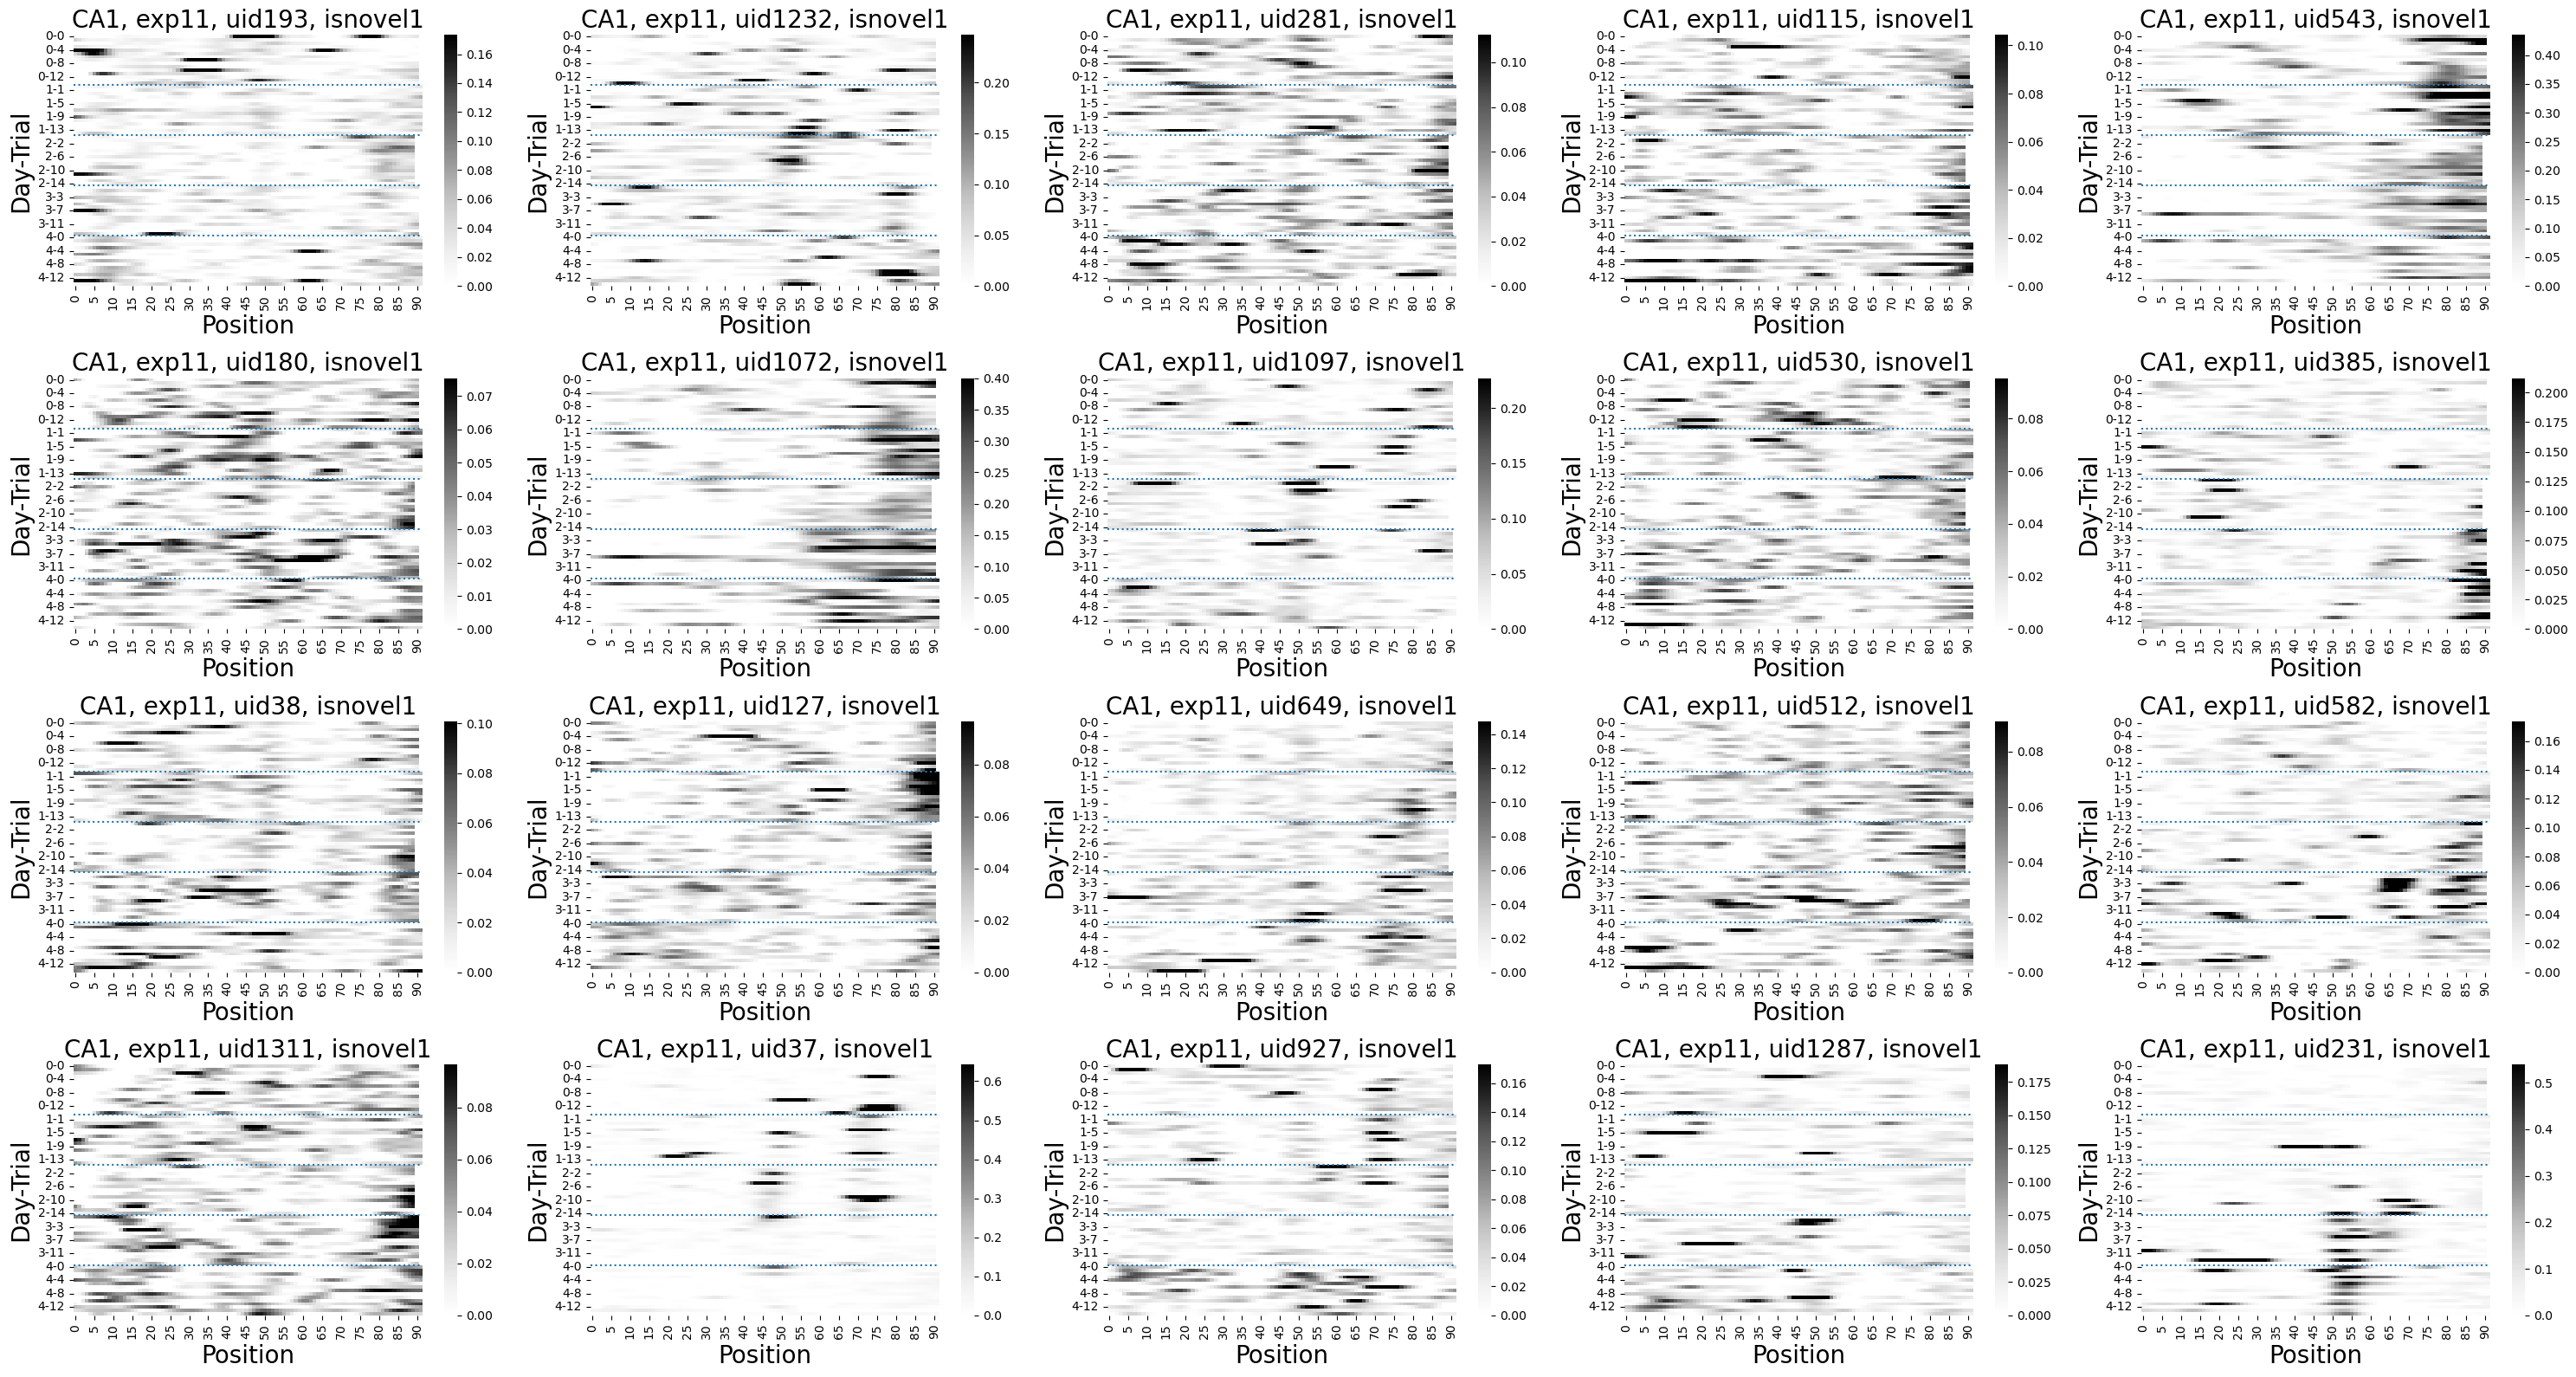

In [225]:
selected=per_cell_metrics_sub.query('si>0.6&corr_half>0.4&corr_half<0.6&fr_cv<1.&sparsity>2.5').sort_values('corr_half',ascending=False).iloc[0:20]
uid_l=selected.index
nplots=len(uid_l)
fig,axs=ph.subplots_wrapper(nplots)
for i in range(nplots):
    ax=axs.ravel()[i]
    uid=uid_l[i]
    X_df = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
    fig,ax=ph.heatmap(X_df.T,vmax_quantile=0.99,fig=fig,ax=ax)
    fig,ax=ph.plot_day_on_heatmap(X_df.T,ax=ax,fig=fig)
    title=f'{region}, exp{exp}, uid{uid}, isnovel{isnovel}'
    ax.set_title(title)
    ax.set_ylabel('Day-Trial')
plt.tight_layout()

In [356]:
# field detection one cell
region='CA1'
exp=9#10
uid=140#126#64#0#
isnovel=0#1#0
get_field_day=1#3#1#


X_df = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
X_df_field = X_df.loc[:,[get_field_day]].dropna(axis=0,how='all').dropna(axis=1,how='all').fillna(method='ffill',axis=0) # 

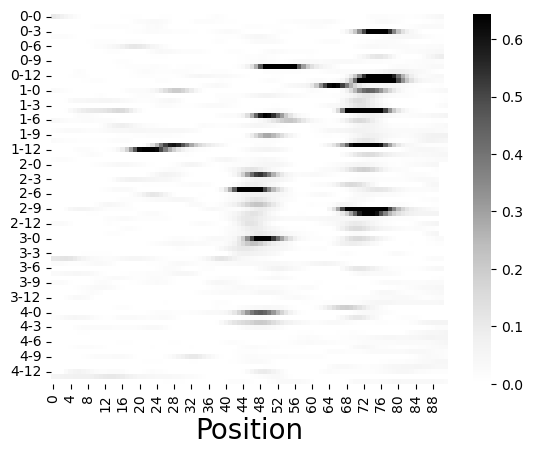

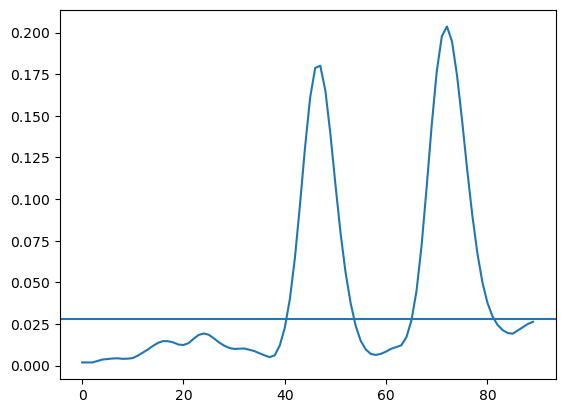

In [227]:
# # for debugging, looking at one day field detection
# field_bounds_final,in_field_mask,out_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up = \
# pfdt.detect_field_using_contiguous_region_with_criteria(X_df_field)

# ph.heatmap(X_df.T,vmax_quantile=0.99)
# plt.figure()
# ax=X_df_field.mean(axis=1).plot()
# ax.axhline(thresh)


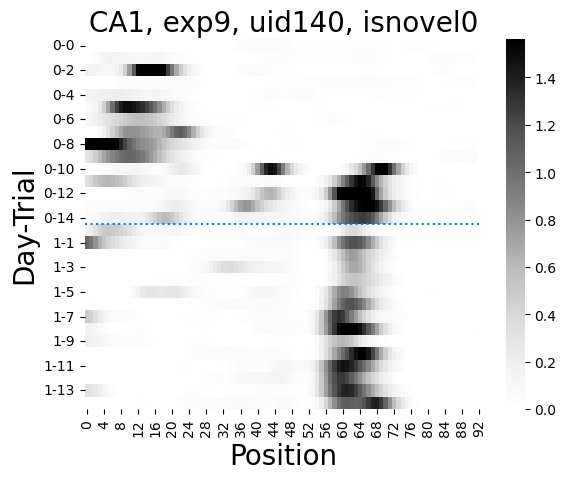

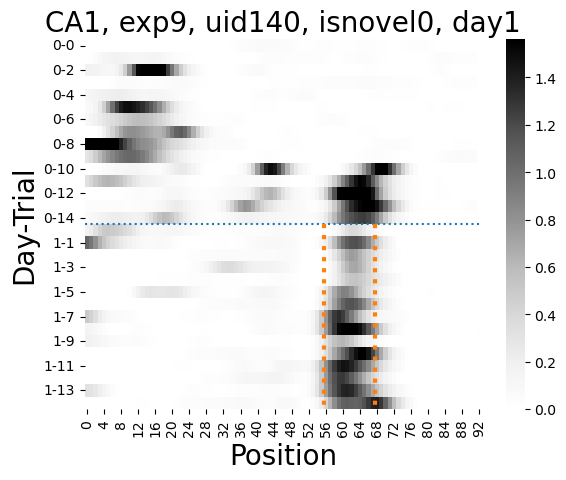

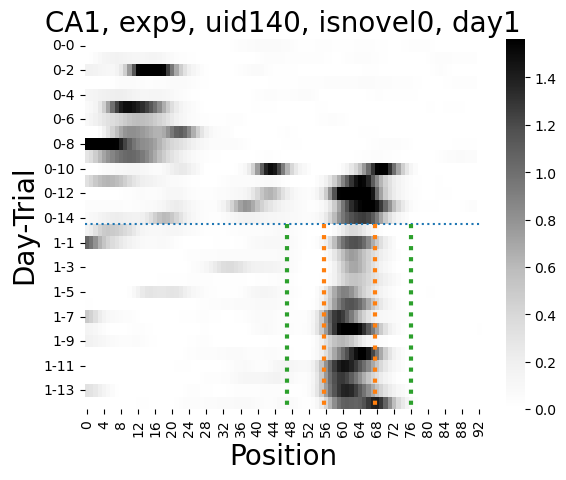

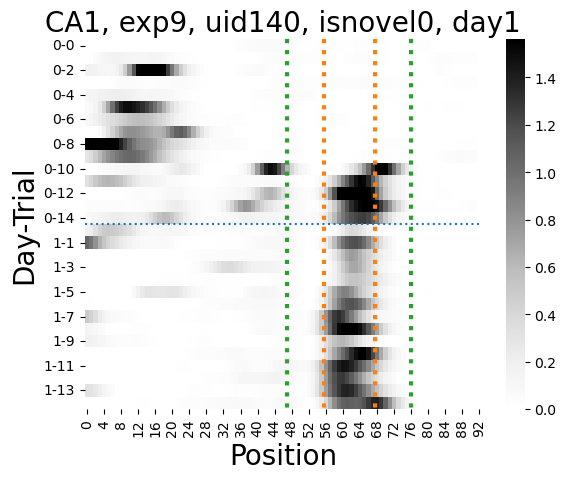

In [357]:
keys_l=['do_field','do_window','by_day','by_previous_day']
cond_l=[[False,False,False,False],[True,False,True,False],[True,True,True,False],[True,True,False,True]]
cond_d_l = [{k:c for k,c in zip(keys_l,cond)} for cond in cond_l]

reload(pfdt)
field_bounds_final_allday, in_field_mask_allday,out_field_mask_allday = pfdt.get_field_all_day_per_cell(X_df,pool_days_for_thresh=True,min_width=4,frac_pooled_thresh=0.6)




# data needed
field_bounds_one = field_bounds_final_allday.loc[[get_field_day]]
window_bounds_one=field_bounds_one[['window_start','window_end']]
# jitter to avoid overlapping bounds
jitter=0.5
window_bounds_one = window_bounds_one.rename(lambda x:x[7:],axis=1) # get rid of window
window_bounds_one['start'] = window_bounds_one['start'] + jitter
window_bounds_one['end'] = window_bounds_one['end'] - jitter
ma = window_bounds_one['end']<field_bounds_one['end']
window_bounds_one.loc[ma,'end'] = field_bounds_one.loc[ma,'end'] + jitter
ma = window_bounds_one['start']>field_bounds_one['start']
window_bounds_one.loc[ma,'start'] = field_bounds_one.loc[ma,'start'] - jitter

X_df

# loop
for cond in cond_d_l:
    # baseline
    fig,ax=ph.heatmap(X_df.T,vmax_quantile=0.99)
    fig,ax=ph.plot_day_on_heatmap(X_df.T,ax=ax,fig=fig)
    if cond['do_field'] or cond['do_window']:
        title=f'{region}, exp{exp}, uid{uid}, isnovel{isnovel}, day{get_field_day}'
    else:
        title=f'{region}, exp{exp}, uid{uid}, isnovel{isnovel}'
    ax.set_title(title)
    ax.set_ylabel('Day-Trial')

    if cond['do_field']:
        fig,ax=ph.add_field_bounds(field_bounds_one,df=X_df.T,by_day=cond['by_day'],by_previous_day=cond['by_previous_day'],fig=fig,ax=ax)
    if cond['do_window']:
        fig,ax=ph.add_field_bounds(window_bounds_one,df=X_df.T,by_day=cond['by_day'],by_previous_day=cond['by_previous_day'],fig=fig,ax=ax,c='C2')
    
        

In [168]:
pre_day_activation_d,test_res_d = pfdt.get_within_out_diff_one_cell_all_day(X_df,in_field_mask_allday=in_field_mask_allday,out_field_mask_allday=out_field_mask_allday)




In [640]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

within vs. outside: Mann-Whitney-Wilcoxon test two-sided, P_val:5.140e-01 U_stat=1.142e+03


[Text(0.5, 17.52222222222222, ''), Text(33.722222222222214, 0.5, 'dF/F')]

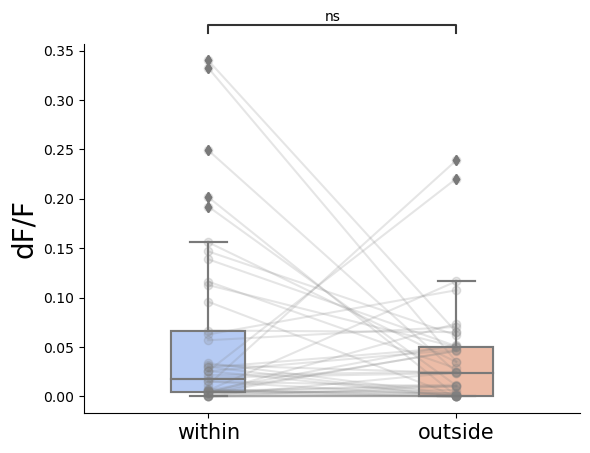

In [169]:
reload(ph)
x='within'
y='outside'
toplot=pre_day_activation_d.loc[get_field_day].unstack('type')[[x,y]]
# toplot=pre_day_activation_d_all.unstack('type')[[x,y]]
fig,ax=ph.paired_line_with_box(toplot,x,y,fig=None,ax=None)
ax.set(xlabel='',ylabel='dF/F')

In [665]:
X_df_field.values.reshape(1,-1,order='F').shape

(1, 930)

In [273]:
db.set_index('region','exp_ind','day_ind').droplevel(level=0)

/tmp/ipykernel_1104914/3010736649.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only.
  db.set_index('region','exp_ind','day_ind').droplevel(level=0)


,exp_ind,day_ind,data_dir_full
region,,,
CA1,0,0,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
CA1,1,0,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
CA1,3,0,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
CA1,4,0,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
CA1,5,0,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
...,...,...,...
DG,10,1,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
DG,11,1,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...
DG,11,2,/mnt/home/szheng/ceph/ad/thomas_data/180301_DG...


In [349]:
# checking the remap trial, whether it's a switching of environment
ddf=db.set_index(['region','exp_ind','day_ind']).loc[(region,exp,0),:].data_dir_full
fn_full=os.path.join(ddf,'preprocessed.p')
prep_res=pickle.load(open(fn_full,'rb'))

In [352]:
0

0

In [317]:
fr_map_trial_df_all_day.loc[(region,exp,0),0].dropna(axis=1,how='all')

0         1         2         3         4         5         6   \
0   0   0.000000  0.000000  0.079191  0.000000  0.000000  0.010970  0.038052   
    1   0.000000  0.000000  0.106231  0.000000  0.000000  0.011206  0.037967   
    2   0.000000  0.003770  0.145738  0.000000  0.000000  0.011402  0.036831   
    3   0.000000  0.007586  0.179878  0.000000  0.000000  0.011469  0.034482   
    4   0.000000  0.009240  0.199881  0.000000  0.000000  0.011760  0.031976   
...          ...       ...       ...       ...       ...       ...       ...   
638 88  0.002432  0.000000  0.032624  0.159285  0.011594  0.092290  0.000000   
    89  0.000000  0.000000  0.035909  0.154072  0.016140  0.100311  0.000000   
    90  0.000000  0.000000  0.038418  0.148295  0.019502  0.105936  0.000000   
    91  0.000000  0.000000  0.039894  0.144331  0.021289  0.108719  0.000000   
    92       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

              7         8         9         10        11        12        13  \
0   0   0.000000  0.589035  0.000000  1.217578  0.037731  0.000000  0.000000   
    1   0.000000  0.824888  0.000000  1.519508  0.031459  0.000000  0.000000   
    2   0.000000  1.178329  0.000000  1.989391  0.024950  0.000000  0.000000   
    3   0.000000  1.452451  0.013281  2.375895  0.020497  0.000000  0.000000   
    4   0.000000  1.529498  0.024072  2.508824  0.017606  0.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
638 88  0.068492  0.001999  0.000000  0.000000  0.029746  0.104012  0.000000   
    89  0.075736  0.007474  0.000000  0.000000  0.037056  0.099626  0.000000   
    90  0.081131  0.010559  0.000000  0.000000  0.041994  0.093245  0.006002   
    91  0.084061  0.011867  0.000000  0.000000  0.044478  0.088791  0.008480   
    92       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

              14  
0   0   0.009500  
    1   0.030325  
    2   0.057085  
    3   0.076150  
    4   0.084399  
...          ...  
638 88  0.013067  
    89  0.000000  
    90  0.000000  
    91  0.000000  
    92       NaN  

[59427 rows x 15 columns]

<Axes: >

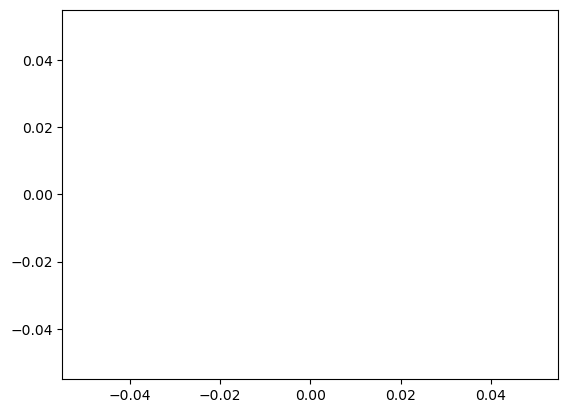

In [353]:
spk_beh_df=prep_res['spk_beh_df']
spk_beh_df.query('trial_type==0&index_within==16')['directed_locomotion'].plot()

In [342]:
reload(pa)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=0.022,nbins=None)

fr_map_dict=pa.get_fr_map_trial(spk_beh_df,prep_res['cell_cols_d']['pyr'],gauss_width=0.1,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=0.5,order=['smooth','divide'])



cant format into a dataframe
cant format into a dataframe


In [346]:
fr_map_dict[0][0].shape

(639, 92, 15)

In [347]:
spk_beh_df

,0,1,2,3,4,5,6,7,8,9,...,637,638,lin,directed_locomotion,index_within,isnovel,trial_type,task_index,trial,lin_binned
0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.000000,-0.0,...,-0.0,0.0,0.829832,0.0,0,0,0,0,0,37
1,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.000000,-0.0,...,-0.0,0.0,0.854422,1.0,0,0,0,0,0,38
2,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.000000,-0.0,...,0.0,0.0,0.866999,1.0,0,0,0,0,0,39
3,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.000000,-0.0,...,0.0,0.0,0.880749,1.0,0,0,0,0,0,39
4,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.000000,-0.0,...,0.0,0.0,0.888742,1.0,0,0,0,0,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8778,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.648625,0.0,...,-0.0,0.0,2.108049,0.0,14,1,1,0,29,95
8779,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.338137,-0.0,...,-0.0,-0.0,2.108645,0.0,14,1,1,0,29,95
8780,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.393756,0.0,...,-0.0,0.0,2.109059,0.0,14,1,1,0,29,95
8781,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.424387,-0.0,...,-0.0,0.0,2.109344,0.0,14,1,1,0,29,95


In [322]:
fr_map_res = fmtas.get_fr_map_one_day(ddf,
                        force_reload=True,load_only=False,dosave=False
                            )

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_9/day_0/fr_map_mask_True.p exists; loading---


In [326]:
fr_map_res['fr_map_trial_df']

0         1         2         3         4         5   \
0 0   0   0.000000  0.002232  0.162905 -0.001997 -0.091269  0.012648   
      1   0.000000  0.002910  0.164065  0.000648 -0.082521  0.011025   
      2   0.000000  0.003862  0.161530  0.004164 -0.070455  0.008500   
      3   0.000000  0.004976  0.150594  0.007242 -0.057986  0.005798   
      4   0.000000  0.006736  0.130023  0.009781 -0.045803  0.003380   
...            ...       ...       ...       ...       ...       ...   
1 638 34  0.021368  0.049277  0.050704  0.014782  0.059824  0.017140   
      35  0.021905  0.053311  0.059679  0.006938  0.062231  0.013763   
      36  0.023218  0.055087  0.066865 -0.002984  0.062510  0.010197   
      37  0.025176  0.055333  0.071796 -0.012401  0.061831  0.007184   
      38  0.026730  0.055063  0.074312 -0.018188  0.061220  0.005437   

                6         7         8         9         10        11  \
0 0   0   0.034149 -0.088435  1.026294  0.013055  1.852238  0.013067   
      1   0.033928 -0.077688  0.964586  0.016124  1.756381  0.009868   
      2   0.033487 -0.060019  0.859631  0.020124  1.580150  0.005172   
      3   0.032796 -0.040389  0.730210  0.023048  1.342870  0.000264   
      4   0.031756 -0.022636  0.589078  0.024161  1.065246 -0.004379   
...            ...       ...       ...       ...       ...       ...   
1 638 34  0.039727  0.034309  0.031793  0.066899  0.060904  0.059579   
      35  0.045232  0.025310  0.049537  0.074383  0.069439  0.069759   
      36  0.052569  0.013773  0.067450  0.081277  0.077808  0.077001   
      37  0.059756  0.002954  0.082394  0.086837  0.084369  0.081304   
      38  0.064267 -0.003697  0.091072  0.090019  0.087970  0.083232   

                12        13        14  
0 0   0  -0.024140 -0.024093  0.062546  
      1  -0.017309 -0.021028  0.065470  
      2  -0.007276 -0.017080  0.069289  
      3   0.003193 -0.014587  0.071682  
      4   0.013212 -0.014711  0.070675  
...            ...       ...       ...  
1 638 34  0.016389  0.033397  0.055092  
      35  0.026716  0.026128  0.062517  
      36  0.040546  0.015372  0.064989  
      37  0.054622  0.004907  0.064017  
      38  0.063923 -0.001555  0.062426  

[49203 rows x 15 columns]

In [360]:
dpp.index_within_to_trial_index(prep_res['spk_beh_df'])

   index
0  0         0
   1         1
   2         2
   3         3
   4         4
   5         5
   6         6
   7         7
   8         8
   9         9
   10       20
   11       21
   12       22
   13       23
   14       24
1  0        10
   1        11
   2        12
   3        13
   4        14
   5        15
   6        16
   7        17
   8        18
   9        19
   10       25
   11       26
   12       27
   13       28
   14       29
Name: 0, dtype: int64

<Axes: >

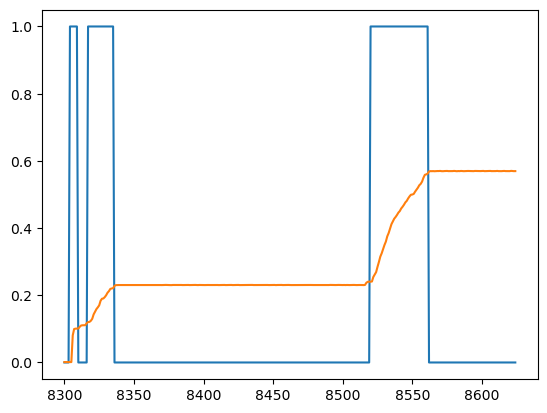

In [311]:
prep_res['spk_beh_df'].query('trial_type==0&index_within==14')['directed_locomotion'].plot()
prep_res['spk_beh_df'].query('trial_type==0&index_within==14')['lin'].plot()

<Axes: >

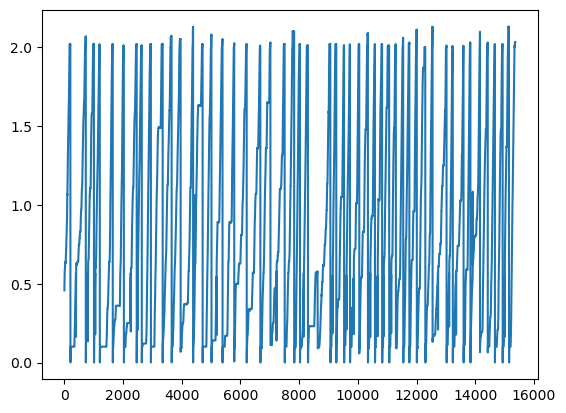

In [301]:
prep_res['spk_beh_df']['lin'].plot()

In [358]:
prep_res['index_within_to_trial_index_df']

isnovel  index_within
0        0                0
         1                1
         2                2
         3                3
         4                4
         5                5
         6                6
         7                7
         8                8
         9                9
         10              20
         11              21
         12              22
         13              23
         14              24
1        0               10
         1               11
         2               12
         3               13
         4               14
         5               15
         6               16
         7               17
         8               18
         9               19
         10              25
         11              26
         12              27
         13              28
         14              29
Name: trial_index, dtype: int64

In [672]:
fn='/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_1/field_detection_withinoutsidediff_True.p'
res = pickle.load(open(fn,'rb'))

In [234]:
# load shuffle nmf result
import detect_field_within_minus_outside_one_exp as dfwmooe
import tqdm
db_grouped = dfwmooe.db_grouped

pre_day_activation_d_all={}
test_res_d_all={}
for i,(region,exp) in enumerate(tqdm.tqdm(db_grouped)):
    try:
        res=dfwmooe.main(i,force_reload=False,dosave=False,load_only=True)

        pre_day_activation_d_all[(region,exp)]=res['pre_day_activation_d_all']
        test_res_d_all[(region,exp)] = res['test_res_d_all']
    except:
        pass
pre_day_activation_d_all=pd.concat(pre_day_activation_d_all,axis=0)

test_res_d_all = pd.concat(test_res_d_all,axis=0)

 10%|▉         | 3/31 [00:00<00:03,  7.59it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_0/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_1/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_3/field_detection_withinoutsidediff_True.p exists; loading---


 16%|█▌        | 5/31 [00:00<00:03,  8.55it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_4/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_5/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_7/field_detection_withinoutsidediff_True.p exists; loading---


 26%|██▌       | 8/31 [00:00<00:02,  8.87it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_8/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_9/field_detection_withinoutsidediff_True.p exists; loading---


 32%|███▏      | 10/31 [00:01<00:03,  5.53it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_10/field_detection_withinoutsidediff_True.p exists; loading---


 39%|███▊      | 12/31 [00:02<00:03,  4.85it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_11/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_12/field_detection_withinoutsidediff_True.p exists; loading---


 45%|████▌     | 14/31 [00:02<00:02,  5.92it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_13/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_14/field_detection_withinoutsidediff_True.p exists; loading---


 65%|██████▍   | 20/31 [00:02<00:00, 13.74it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA3/exp_0/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA3/exp_3/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA3/exp_5/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA3/exp_6/field_detection_withinoutsidediff_True.p exists; loading---


 81%|████████  | 25/31 [00:02<00:00, 16.34it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_0/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_3/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_5/field_detection_withinoutsidediff_True.p exists; loading---


 97%|█████████▋| 30/31 [00:03<00:00, 17.08it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_7/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_8/field_detection_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_9/field_detection_withinoutsidediff_True.p exists; loading---


100%|██████████| 31/31 [00:03<00:00,  9.33it/s]


/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_11/field_detection_withinoutsidediff_True.p exists; loading---


In [258]:
pre_day_activation_all_avg_trial=pre_day_activation_d_all.unstack('day_pre').unstack('trial').mean(axis=1).unstack('type')



In [259]:
pre_day_activation_all_avg_trial=pd.concat([pre_day_activation_all_avg_trial,test_res_d_all],axis=1)
pre_day_activation_all_avg_trial = pre_day_activation_all_avg_trial.dropna(axis=0)

In [262]:
pval_thresh = 0.05
sig_more_within=(pre_day_activation_all_avg_trial['diff'] > 0)&(pre_day_activation_all_avg_trial['pval']<pval_thresh)
pre_day_activation_all_avg_trial['sig_more_within'] = sig_more_within

RanksumsResult(statistic=61.76931144248685, pvalue=0.0)
RanksumsResult(statistic=45.42785976874513, pvalue=0.0)
RanksumsResult(statistic=19.366735552814657, pvalue=1.4730614044955897e-83)
RanksumsResult(statistic=8.982563944173444, pvalue=2.6452915759934113e-19)
RanksumsResult(statistic=28.787790923885765, pvalue=3.049836631009738e-182)
RanksumsResult(statistic=27.055400444408335, pvalue=3.2996417044096048e-161)


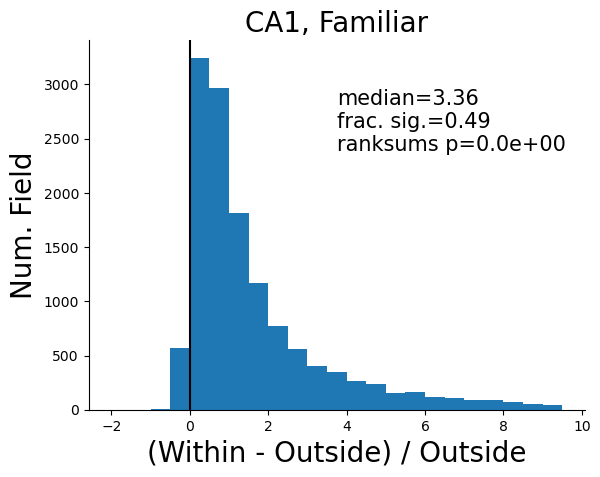

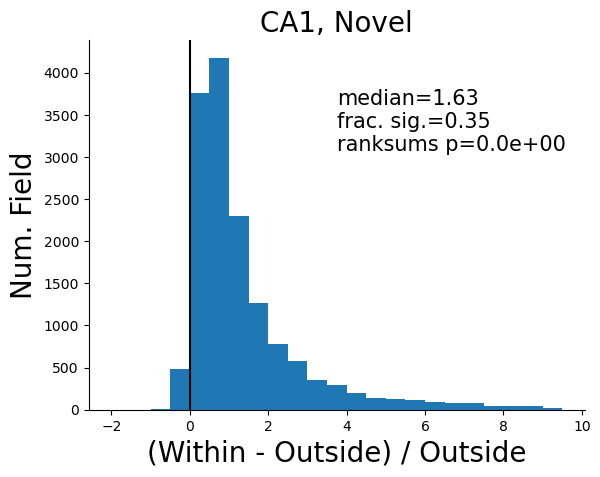

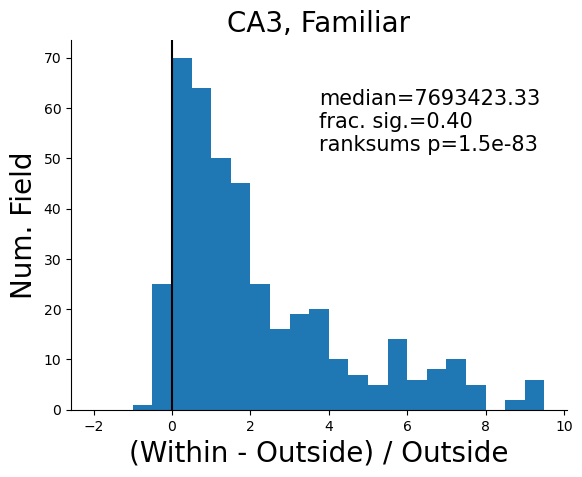

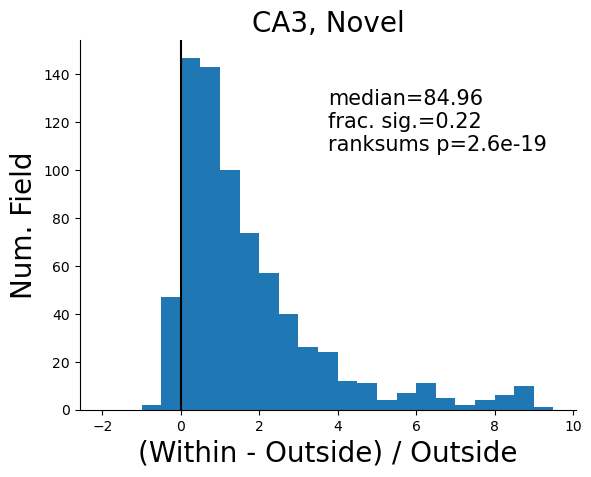

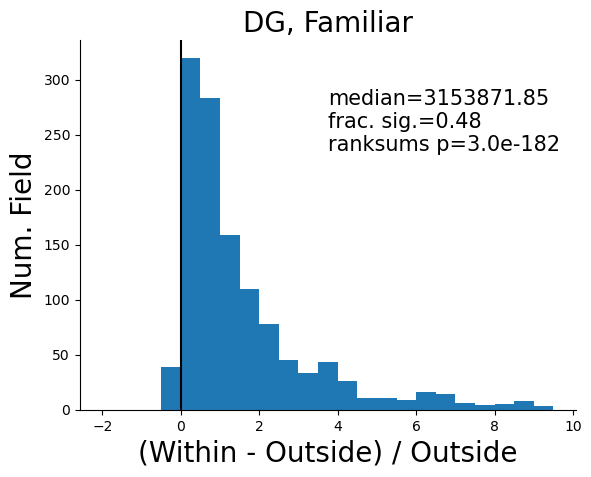

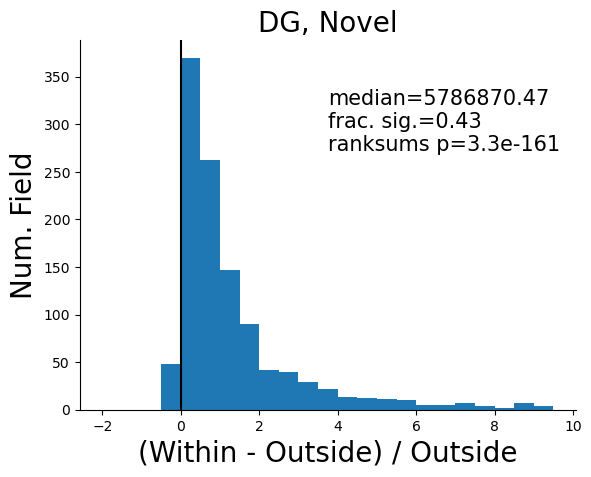

In [264]:
gpb=pre_day_activation_all_avg_trial.groupby(level=(0,2))
dosave=True
for (region,isnovel),_ in gpb:
# region='CA1'
# isnovel = 0
    xx=pre_day_activation_all_avg_trial.loc[region,slice(None),isnovel]
    population_test = scipy.stats.ranksums(xx['within'],xx['outside'])
    print(population_test)
    tohist_key='diff_frac'
    tohist_val=xx[tohist_key]
    fig,ax=plt.subplots()
    ax.hist(tohist_val,bins=np.arange(-2,10,0.5))
    median=tohist_val.median()
    frac_sig=xx['sig_more_within'].mean()
    sns.despine()
    ax.set(xlabel='(Within - Outside) / Outside',ylabel='Num. Field')
    text=f'median={median:.02f}\nfrac. sig.={frac_sig:.02f}\nranksums p={population_test.pvalue:.01e}'
    ax.axvline(0,color='k')
    ax.text(0.5,0.7,text,fontsize=15,transform=ax.transAxes)
    isnovel_str = ['Familiar','Novel'][isnovel]
    ax.set_title(f'{region}, {isnovel_str}')
    
    if dosave:
        for fmt in ['svg','png']:
            fig_fn = f'frac_increase_within_field_hist_{region}_{isnovel_str}.{fmt}'
            fig_fn_full = os.path.join(figdir,fig_fn)
            fig.savefig(fig_fn_full,bbox_inches='tight')
    

In [10]:
import detect_field_within_minus_outside_one_exp as dfwmooe
reload(pfdt)
reload(dfwmooe)
res=dfwmooe.main(1)


100%|██████████| 772/772 [00:06<00:00, 120.22it/s]


saved at /mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_1/field_detection_withinoutsidediff_True.p


In [42]:
pre_day_activation_d_all_unstack['diff_frac'].sort_values()

        get_field_day  day_pre  trial
1  258  1              0        18      -1.0
   340  1              0        12      -1.0
0  6    1              0        6       -1.0
1  242  1              0        14      -1.0
   5    1              0        18      -1.0
                                        ... 
   359  1              0        20       NaN
                                21       NaN
                                22       NaN
                                23       NaN
                                24       NaN
Name: diff_frac, Length: 16858, dtype: float64

In [ ]:
pre_day_activation_d_all=res['pre_day_activation_d_all']

pre_day_activation_d_all_unstack=pre_day_activation_d_all.unstack('type')
pre_day_activation_d_all_unstack['diff_frac'] = (pre_day_activation_d_all_unstack['within']-pre_day_activation_d_all_unstack['outside'])/(pre_day_activation_d_all_unstack['outside']+1e-10)


pre_day_activation_d_all_unstack['diff_frac'].hist(bins=np.arange(-3,20))

In [462]:
# field detection one cell
region='CA1'
exp=0
uid=0#64
isnovel=0
get_field_day=1#2


X_df = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
X_df_field = X_df.loc[:,[get_field_day]].dropna(axis=0,how='all').fillna('ffill',axis=0) # 

In [456]:
field_bounds_final_allday, in_field_mask_allday,out_field_mask_allday = pfdt.get_field_all_day_per_cell(X_df_,pool_days_for_thresh=True)



In [464]:
gpb = X_df.groupby(level=0,axis=1)
X_df_med = X_df.median(axis=1)
highest=gpb.median().max(axis=1).max() # use the max of all (medians within days) 
baseline_quantile=0.25
baseline=X_df_med.quantile(baseline_quantile)

In [486]:
reload(pfdt)
field_bounds_final,in_field_mask,out_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up=pfdt.detect_field_using_contiguous_region_with_criteria(X_df_field,baseline_quantile=0.25,max_baseline_diff_frac=0.25,
                                                       highest=highest,baseline=baseline,
                                        min_width=3,in_out_ratio=3.,frac_sig_transient=0.2,
                                        n_min_roll = 10,nrepeats =1000,up_quantile=0.8,low_quantile=0.1,
                                                       outfield_frac_pos = 0.1,
                                                outfield_frac_size_thresh = 0.05,do_get_window_outside=False
                                        
                                       )
print(field_bounds_final)

   start  end
0      4   13
1     55   62


<Axes: >

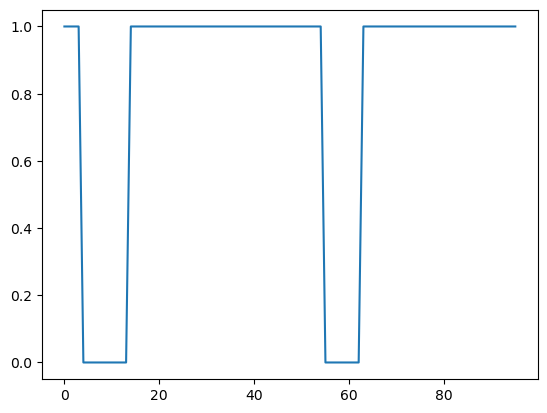

In [489]:
out_field_mask.astype(int).plot()

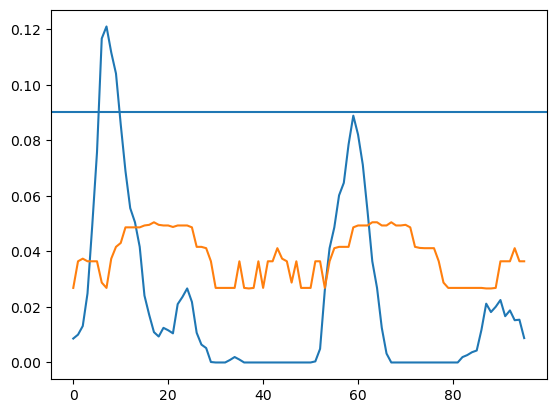

In [477]:
plt.plot(X_df_field_avg)
plt.plot(X_v_avg_shuffle_up)
plt.axhline(thresh)

KeyError: '[1] not in index'

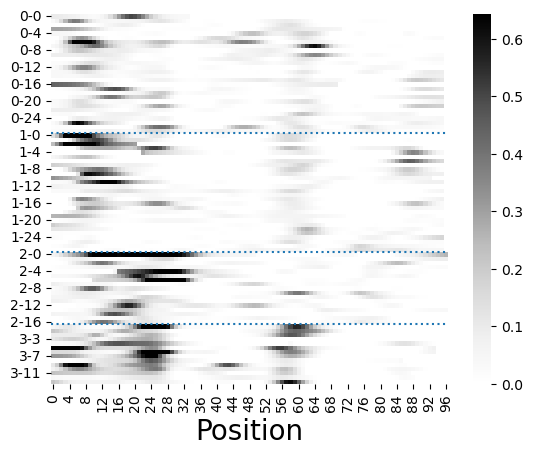

In [468]:
reload(ph)
fig,ax=ph.heatmap(X_df_.T)
fig,ax=ph.plot_day_on_heatmap(X_df_.T,ax=ax,fig=fig)
field_bounds_one = field_bounds_final_allday.loc[[get_field_day]]
fig,ax=ph.add_field_bounds(field_bounds_one,df=X_df_.T,by_day=True,fig=fig,ax=ax)
title=f'{region}, exp{exp}, uid{uid}, isnovel{isnovel}, day{get_field_day}'
ax.set_title(title)


In [390]:
def get_window_outside(field_bounds_final,npos,outfield_frac_pos = 0.1,
                    outfield_frac_size_thresh = 0.05,
                        **kwargs):
    '''
    # get window outside of field, and an outfield mask based on that
    '''
    outfield_size_thresh = int(npos * outfield_frac_size_thresh)
    npos_out = int(npos * outfield_frac_pos)
    n_field = field_bounds_final.shape[0]
#     width = field_bounds_final['end']-field_bounds_final['start']
#     npos_out_half_width = width//2
#     to_extend=np.minimum(npos_out_half_width,npos_out)
    to_extend=npos_out
    field_bounds_final['window_start'] = np.maximum(field_bounds_final['start'] - to_extend,0)
    field_bounds_final['window_end'] = np.minimum(field_bounds_final['end'] + to_extend,npos-1)
    out_field_mask = pd.Series(False,index=in_field_mask.index)
    for i,row in field_bounds_final.iterrows():
        if i>0:
            prev_end = field_bounds_final.loc[i-1,'end']
            window_start=field_bounds_final.loc[i,'window_start']
            if window_start < prev_end:
                window_start = prev_end
                field_bounds_final.loc[i,'window_start']=window_start
        if i< (n_field-1):
            next_start = field_bounds_final.loc[i+1,'start']
            window_end=field_bounds_final.loc[i,'window_end']
            if window_end > next_start:
                window_end = next_start
                field_bounds_final.loc[i,'window_end']=window_end
    for i,row in field_bounds_final.iterrows():
        out_field_mask.loc[row['window_start']:row['start']-1] = True
        out_field_mask.loc[row['end']+1:row['window_end']] = True



    out_of_field_size=(field_bounds_final['window_end'] - field_bounds_final['end']) + (field_bounds_final['start'] - field_bounds_final['window_start'])
    ma = out_of_field_size > outfield_size_thresh
    field_bounds_final = field_bounds_final.loc[ma]
    return field_bounds_final, out_field_mask 

In [391]:
def detect_field_using_contiguous_region_with_criteria(X_df_field,baseline_quantile=0.25,max_baseline_diff_frac=0.25,
                                                       highest=None,baseline=None,
                                        min_width=3,in_out_ratio=3.,frac_sig_transient=0.2,
                                        n_min_roll = 10,nrepeats =1000,up_quantile=0.8,low_quantile=0.1,
                                                       outfield_frac_pos = 0.1,
                                                outfield_frac_size_thresh = 0.05,
                                                       **kwargs
                                       ):
    # check the active cell criterion
            
    if (X_df_field>0.0).mean().mean() <= frac_sig_transient:
        
        return

    X_df_field_avg,X_v_avg_shuffle_mean,X_v_avg_shuffle_up,X_v_avg_shuffle_low=\
        get_frmap_shuffle(X_df_field,n_min_roll = n_min_roll,nrepeats = nrepeats,up_quantile=up_quantile,low_quantile=low_quantile)
    
    # get contiguous chunks
    X_df_field_avg= X_df_field.median(axis=1)
    npos = X_df_field_avg.shape[0]
    if highest is None: # can be inherited from all days
        highest=X_df_field_avg.max()
    if baseline is None:
        baseline=X_df_field_avg.quantile(baseline_quantile)
    thresh = max_baseline_diff_frac*(highest-baseline)
    in_field_mask = X_df_field_avg > thresh
    field_bounds_tentative = get_contiguous_chunks(X_df_field_avg,thresh)
    X_out_field = X_df_field_avg.loc[X_df_field_avg <= thresh]
    X_out_field_mean = X_out_field.mean()
    
    # discard small field
    ma = field_bounds_tentative['end']-    field_bounds_tentative['start'] > min_width
    field_bounds_tentative = field_bounds_tentative.loc[ma]
    
    # check the in field gain criterion
    ma=[]
    for i,row in field_bounds_tentative.iterrows():
        within = X_df_field_avg.loc[row['start']:row['end']].mean()
        satisfy_inout = (within / (X_out_field_mean + 1e-10)) > in_out_ratio
        if not satisfy_inout:
            in_field_mask.loc[row['start']:row['end']]=False
        ma.append(satisfy_inout)
    ma=np.array(ma)
    field_bounds_tentative_afterinout = field_bounds_tentative.loc[ma]
        
    # check peak above null
    ma=[]
    for i,row in field_bounds_tentative_afterinout.iterrows():
        st,ed=row['start'],row['end']
        satisfy_shuffle_peak = (X_df_field_avg.loc[st:ed] > X_v_avg_shuffle_up[st:ed+1]).sum()>0
        if not satisfy_shuffle_peak:
            in_field_mask.loc[row['start']:row['end']]=False
        ma.append(satisfy_shuffle_peak)
    field_bounds_final = field_bounds_tentative_afterinout.loc[ma].reset_index(drop=True)
    
#     out_field_mask = np.logical_not(in_field_mask)

    
    field_bounds_final,out_field_mask = get_window_outside(field_bounds_final,npos,outfield_frac_pos = outfield_frac_pos,
                    outfield_frac_size_thresh = outfield_frac_size_thresh)
    
    return field_bounds_final,in_field_mask,out_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up



(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='Position'>)

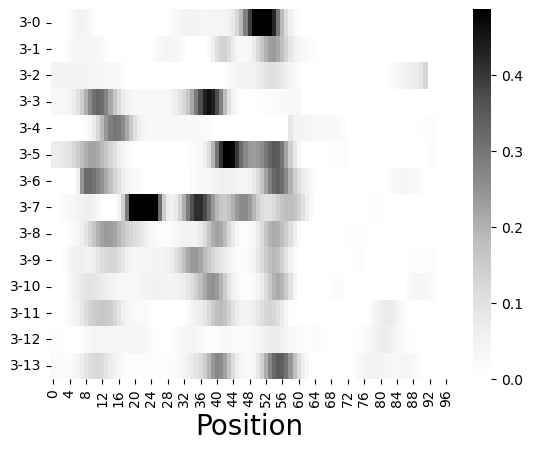

In [341]:
ph.heatmap(X_df_field.T)

In [346]:
get_field_day = 3
X_df_field = X_df_.loc[:,[get_field_day]].dropna(axis=0,how='all')
field_bounds_final,in_field_mask,out_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up = detect_field_using_contiguous_region_with_criteria(X_df_field)


In [347]:
field_bounds_final

,start,end,window_start,window_end
0,7,17,2,22
1,35,44,31,48
2,49,59,44,64


<Axes: >

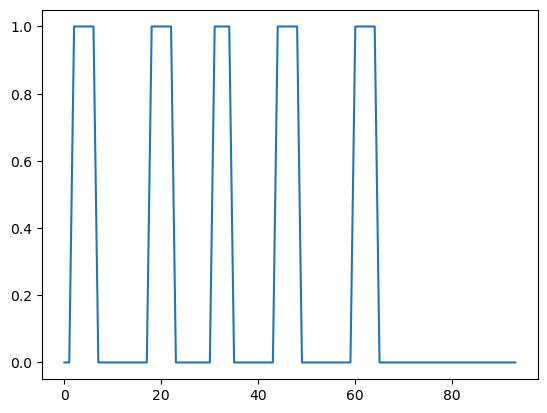

In [348]:
out_field_mask.astype(int).plot()

In [418]:
import place_field_detection_thomas as pfdt
reload(pfdt)
field_bounds_all, in_field_mask_all, out_field_mask_all = pfdt.get_field_all_day_all_cell(fr_map_trial_df_all_day_sub)




100%|██████████| 1148/1148 [04:25<00:00,  4.33it/s]


In [421]:
in_field_mask_all

0  0    0  0     False
           1     False
           2     False
           3     False
           4     False
                 ...  
1  573  3  90    False
           91    False
           92    False
           93    False
           94    False
Length: 415576, dtype: bool

In [432]:
reload(pfdt)
pre_day_activation_d_all, test_res_d_all = pfdt.get_within_out_diff_all_cell_all_day(fr_map_trial_df_all_day_sub,in_field_mask_all=in_field_mask_all,out_field_mask_all=out_field_mask_all)



100%|██████████| 1148/1148 [00:15<00:00, 75.02it/s]


In [431]:
pre_day_activation_d.dropna()

Series([], dtype: float64)

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='Position'>)

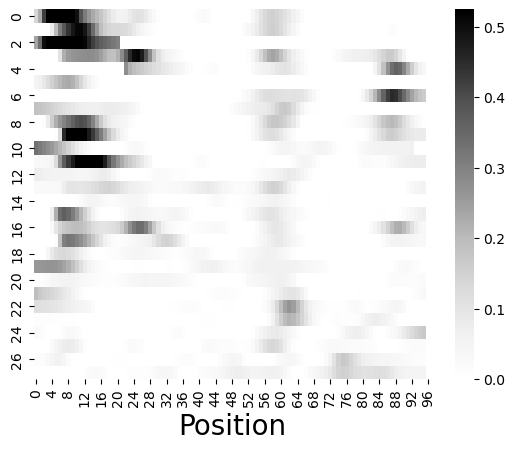

In [449]:
ph.heatmap(fr_map_trial_df_all_day_sub.loc[(0,0),1].T)

<Axes: >

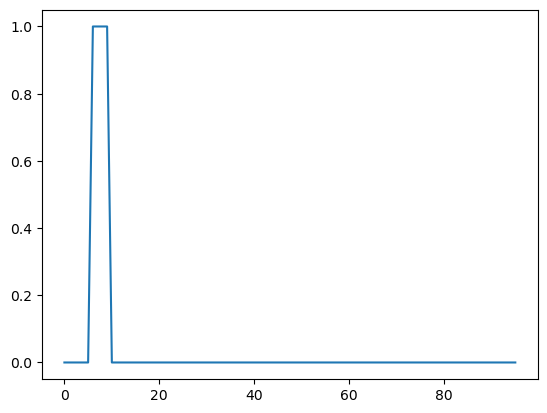

In [445]:
in_field_mask_all.loc[0,0,1].astype(int).plot()

<Axes: >

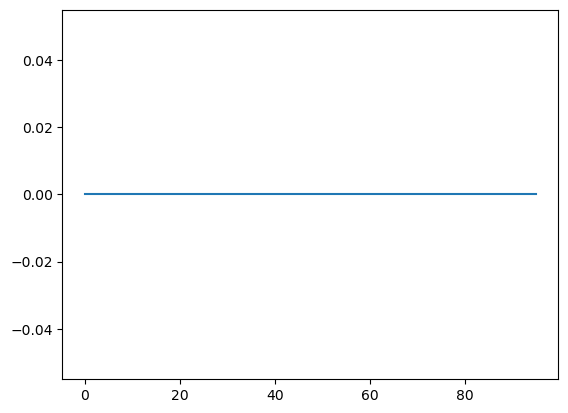

In [444]:
out_field_mask_all.loc[0,0,1].astype(int).plot()

In [439]:
pre_day_activation_d_all.unstack(level='trial').mean(axis=1).unstack('type')

type                             diff   outside         ratio    within
      get_field_day day_pre                                            
0 0   1             0             NaN       NaN           NaN  0.160355
      2             0       -0.014842  0.089749  1.744948e+00  0.074907
                    1       -0.024315  0.102030  8.538956e+02  0.077715
      3             0        0.038936  0.046720  2.808237e+00  0.085655
                    1        0.059666  0.035165  2.544251e+00  0.094831
...                               ...       ...           ...       ...
1 492 2             0        0.010710  0.058103  1.194481e+07  0.068813
                    1       -0.018225  0.042779  8.030667e-01  0.024554
      3             0       -0.005922  0.037871  1.469772e+00  0.031950
                    1        0.004664  0.025817  1.355589e+00  0.030481
                    2       -0.003989  0.020370  1.075966e+00  0.016381

[6105 rows x 4 columns]

In [435]:
pre_day_activation_d_all.unstack('type')

type                                   diff   outside     ratio    within
      get_field_day day_pre trial                                        
0 0   1             0       0           NaN       NaN       NaN  0.046699
                            1           NaN       NaN       NaN  0.266653
                            2           NaN       NaN       NaN  0.000000
                            3           NaN       NaN       NaN  0.219983
                            4           NaN       NaN       NaN  0.006524
...                                     ...       ...       ...       ...
1 492 3             2       4     -0.009479  0.019158  0.505215  0.009679
                            5      0.000664  0.016208  1.040957  0.016872
                            6     -0.018899  0.029770  0.365157  0.010871
                            7      0.014908  0.023701  1.628974  0.038609
                            8     -0.016325  0.026848  0.391956  0.010523

[116813 rows x 4 columns]

In [433]:
pre_day_activation_d_all.loc[1,573,3,'within']

/tmp/ipykernel_1072048/1904664293.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  pre_day_activation_d_all.loc[1,573,3,'within']


day_pre  trial
0        0        0.005969
         1        0.016233
         2        0.045843
         3        0.060492
         4        0.015668
         5        0.083885
         6        0.083902
         7        0.046766
         8        0.042565
         9        0.019218
         10       0.014253
1        0        0.019681
         1        0.052338
         2        0.059832
         3        0.035185
         4        0.154709
         5        0.029086
         6        0.029088
         7        0.029167
         8        0.052652
         9        0.088144
         10       0.049293
         11       0.076204
         12       0.037786
         13       0.075407
         14       0.084520
2        0        0.003005
         1        0.014475
         2        0.018538
         3        0.017513
         4        0.018591
         5        0.008667
         6        0.018071
         7        0.009626
         8        0.001329
dtype: float64

In [306]:
# field detection all cells
from itertools import islice
fr_map_trial_df_all_day_sub = fr_map_trial_df_all_day.loc[(region,exp),:].dropna(axis=1,how='all').dropna(axis=0,how='all')
gpb = fr_map_trial_df_all_day_sub.groupby(level=(0,1)) # isnovel, uid




In [392]:
def get_within_out_diff_one_cell_one_day(X_df_compare,in_field_mask,out_field_mask=None):
    pre_day_activation = {}
#     pdb.set_trace()
    common_pos=in_field_mask.index.intersection(X_df_compare.index).intersection(out_field_mask.index) # don't miss .index!!
    X_df_compare = X_df_compare.loc[common_pos]
    in_field_mask = in_field_mask.loc[common_pos]
    out_field_mask = out_field_mask.loc[common_pos]
    pre_day_activation['within'] = X_df_compare.loc[in_field_mask].mean()
    
    if out_field_mask is None:
        out_field_mask = np.logical_not(in_field_mask)
    pre_day_activation['outside'] = X_df_compare.loc[out_field_mask].mean()
    pre_day_activation['diff'] = pre_day_activation['within'] - pre_day_activation['outside']
    eps = 1e-10
    pre_day_activation['ratio'] = pre_day_activation['within'] / (pre_day_activation['outside'] + eps)
    test_res=scipy.stats.ranksums(pre_day_activation['within'],pre_day_activation['outside'])
    pre_day_activation = pd.concat(pre_day_activation,axis=0)
    pre_day_activation.index.rename(('type','day_pre','trial'),level=(0,1,2),inplace=True)
    return pre_day_activation,test_res

def get_within_out_diff_one_cell_all_day(X_df,in_field_mask_allday=None,out_field_mask_allday=None,**kwargs):
    if in_field_mask_allday is None:
        field_bounds_final_allday, in_field_mask_allday,out_field_mask_allday = get_field_all_day_per_cell(X_df,**kwargs)
    day_l = X_df.columns.get_level_values(0).unique()
    pre_day_activation_d={}
    test_res_d={}
    for d in day_l[1:]:
        get_field_day = d
        X_df_compare = X_df.loc[:,:(get_field_day-1)]
        in_field_mask = in_field_mask_allday.loc[get_field_day]
        out_field_mask = out_field_mask_allday.loc[get_field_day]
        pre_day_activation,test_res = get_within_out_diff_one_cell_one_day(X_df_compare,in_field_mask,out_field_mask=out_field_mask)
        pre_day_activation_d[d] = pre_day_activation
        test_res_d[d] = test_res
    pre_day_activation_d = pd.concat(pre_day_activation_d,axis=0)
    pre_day_activation_d.index.rename('get_field_day',level=0,inplace=True)
    test_res_d=pd.DataFrame(test_res_d).T.dropna(axis=0,how='all') # drop the no field days
    test_res_d.index.rename('get_field_day')
    test_res_d.columns=['stat','pval']
    return pre_day_activation_d,test_res_d


In [ ]:
get_within_out_diff_one_cell_one_day(X_df_compare,in_field_mask,out_field_mask=None)

In [353]:
pre_day_activation_d,test_res_d=get_within_out_diff_one_cell_all_day(X_df_,in_field_mask_allday=None)

In [381]:
out_field_mask.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93],
           dtype='int64')

In [399]:
get_field_day=1
X_df_compare = X_df_.loc[:,:(get_field_day-1)]
field_bounds_all, in_field_mask_all, out_field_mask_all = get_field_all_day_per_cell(X_df_,pool_days_for_thresh=True)
in_field_mask = in_field_mask_allday.loc[get_field_day]
out_field_mask=out_field_mask_all.loc[get_field_day]
pre_day_activation,test_res = get_within_out_diff_one_cell_one_day(X_df_compare,in_field_mask,out_field_mask=out_field_mask)
import reuse_block_analysis as rba
per_field_pre_activation=rba.get_activation_all_field(X_df_compare,field_bounds_all.loc[get_field_day])


In [405]:
scipy.stats.ranksums(per_field_pre_activation.loc['within'].T,
per_field_pre_activation.loc['outside'].T)

RanksumsResult(statistic=array([-0.33593018, -0.47521831]), pvalue=array([0.73692352, 0.63463138]))

In [394]:
test_res

RanksumsResult(statistic=0.36870385800626, pvalue=0.7123484727820723)

In [364]:
in_field_mask_all

0  0     False
   1     False
   2     False
   3     False
   4     False
         ...  
3  89    False
   90    False
   91    False
   92    False
   93    False
Length: 383, dtype: bool

In [357]:
pre_day_activation

type    day_pre  trial
within  0        0       NaN
                 1       NaN
                 2       NaN
                 3       NaN
                 4       NaN
                          ..
ratio   2        12      NaN
                 13      NaN
                 14      NaN
                 15      NaN
                 16      NaN
Length: 292, dtype: float64

In [216]:
field_bounds_all, in_field_mask_all = get_field_all_day_all_cell(fr_map_trial_df_all_day_sub,pool_days_for_thresh=True)



 46%|████▌     | 524/1148 [00:13<00:15, 39.76it/s]

KeyboardInterrupt



In [69]:
field_bounds_final_allday, in_field_mask_allday = get_field_all_day_per_cell(X_df_[[3]])

In [37]:
field_bounds_final_allday

,,start,end
2,3,22,30


(<Figure size 432x288 with 2 Axes>, <Axes: xlabel='Position'>)

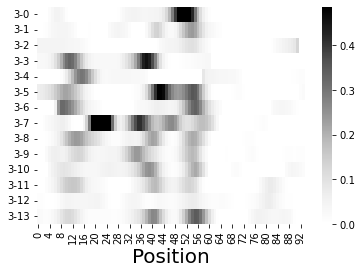

In [20]:
ph.heatmap(X_df_field.T)

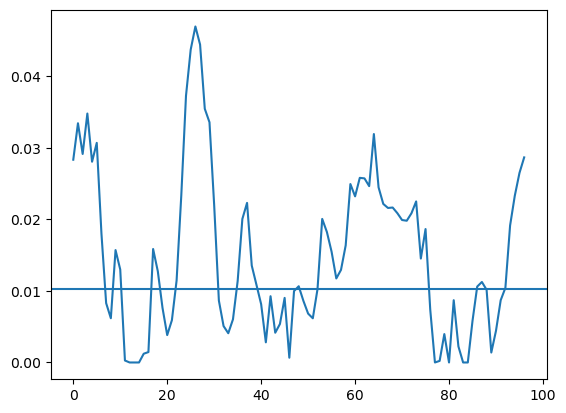

In [99]:
field_bounds_final,in_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up = detect_field_using_contiguous_region_with_criteria(X_df_field,baseline_quantile=0.25,max_baseline_diff_frac=0.25,
                                        min_width=3,in_out_ratio=3.,frac_sig_transient=0.2)
# print(field_bounds_tentative_afterinout)
fig,ax=plt.subplots()
ax.plot(X_df_field_avg)
ax.axhline(thresh)

<Axes: >

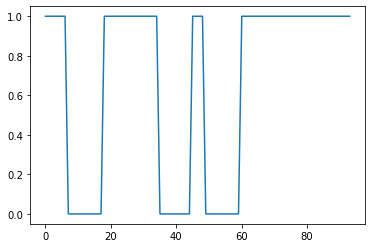

In [26]:
out_field_mask.astype(int).plot()

In [186]:
field_bounds_tentative

,start,end
0,6,11
1,12,26
2,38,62


In [156]:
max_frac_thresh=0.2
# def trace_each_peak(peak_x,X_df_field_avg,max_frac_thresh=0.2):
peak_x = sig_peaks[0]

xs=X_df_field_avg.index


field_bound_val=X_df_field_avg.loc[peak_x] * max_frac_thresh #value at tentative boundary for each field
X_df_field_avg-field_bound_val
    
    
    
    

0    -0.039890
1    -0.025516
2    -0.018889
3    -0.016163
4    -0.009005
        ...   
89   -0.058599
90   -0.073141
91   -0.081728
92   -0.082640
93   -0.083110
Length: 94, dtype: float64

<Axes: >

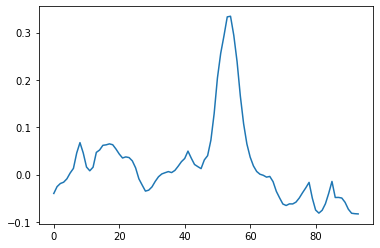

In [157]:
(X_df_field_avg-field_bound_val).plot()

In [142]:
uid = 83

0.03528219949089784

In [150]:
X_df_field_avg

0     0.043723
1     0.058097
2     0.064724
3     0.067449
4     0.074608
        ...   
89    0.025014
90    0.010471
91    0.001885
92    0.000972
93    0.000502
Length: 94, dtype: float64

In [151]:
X_df_field_avg.quantile(0.25)

0.04829017087598335

si          0.305278
fr_cv       0.423235
mean_fr     0.149515
sparsity    1.631766
Name: (CA1, 0, 3, 0, 83), dtype: float64


(<Figure size 432x288 with 2 Axes>, <Axes: xlabel='Position'>)

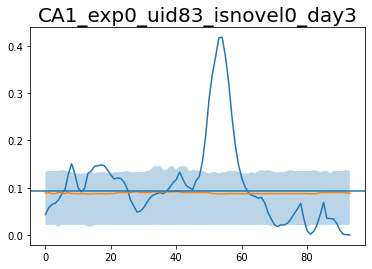

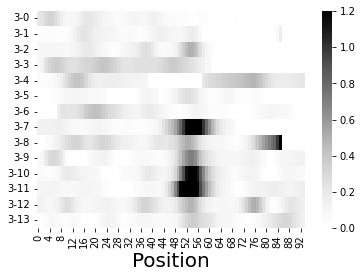

In [159]:
# uid = 76
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
X_df_field = X_df_.loc[:,[get_field_day]].dropna(axis=0,how='all').fillna('ffill',axis=0) # 
sig_peaks,X_df_field_avg,X_v_avg_shuffle_mean,X_v_avg_shuffle_up,X_v_avg_shuffle_low = shuffle_test_frmap_get_peaks(X_df_field,n_min_roll = 10,nrepeats = 1000,up_quantile=0.8,low_quantile=0.1)

fig,ax=plt.subplots()
ax.plot(xs,X_df_field_avg)
ax.plot(xs,X_v_avg_shuffle_mean)
ax.fill_between(xs,X_v_avg_shuffle_up,X_v_avg_shuffle_low,alpha=0.3)

ax.axhline(0.25*(X_df_field_avg.max()-X_df_field_avg.quantile(0.25)))

title=f'{region}_exp{exp}_uid{uid}_isnovel{isnovel}_day{get_field_day}'
ax.set_title(title)
print(per_cell_metrics.loc[region,exp,get_field_day,isnovel,uid])
ph.heatmap(X_df_field.T)
# uid = uid+1


In [122]:
import reuse_block_analysis as rba

In [144]:

# prep all days
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')

compare_day = 0#2


X_df_field = X_df_.loc[:,[get_field_day]] # 

X_df = X_df_field

reload(unmf)
n_basis = 20#20#20
# lam_beta=lam_beta_cross=20
# lam_beta=40
# lam_beta_cross=10
lam_beta=lam_beta_cross=20.#20.

# lam_beta=lam_beta_cross = 20.#1.
lam_h = 0.1
rtol=1e-3
# lam_beta_cross = 10.#0.1
norm_W='mean' # 'max'
W_hat_ma, H_hat_ma,X_hat, loss_history = unmf.do_unimodal_nmf_wrapper(X_df,ma_thresh=0.05,clip_ratio=0.99,
                                                                n_components=n_basis,lam_beta=lam_beta,lam_h=lam_h,lam_beta_cross=lam_beta_cross,
                                                                n_basis=n_basis,
                                                                n_iter_max=100,rtol=rtol,
                                                                verbose=True,norm_H=None,norm_W=norm_W
                                                               )

recon = loss_history['reconstruction'].iloc[-1]

field_range=rba.get_field(W_hat_ma,extend=2,max_thresh=0.2,out_of_field_size_thresh=5)


iter0--tot: 145.64533, recon: 32.38062, reg_beta: 0.40121, reg_H: 8.14760, reg_beta_cross: 104.71590
iter1--tot: 284.51239, recon: 23.81110, reg_beta: 1.09994, reg_H: 7.81879, reg_beta_cross: 251.78256
iter2--tot: 294.73896, recon: 23.53752, reg_beta: 1.15104, reg_H: 7.76202, reg_beta_cross: 262.28838
iter3--tot: 295.99719, recon: 23.50871, reg_beta: 1.15655, reg_H: 7.75281, reg_beta_cross: 263.57912
iter4--tot: 296.15296, recon: 23.50510, reg_beta: 1.15727, reg_H: 7.75170, reg_beta_cross: 263.73890
iter5--tot: 296.17572, recon: 23.50451, reg_beta: 1.15738, reg_H: 7.75159, reg_beta_cross: 263.76223
iter6--tot: 296.17946, recon: 23.50441, reg_beta: 1.15740, reg_H: 7.75158, reg_beta_cross: 263.76607
iter7--tot: 296.18015, recon: 23.50438, reg_beta: 1.15740, reg_H: 7.75158, reg_beta_cross: 263.76678
iter8--tot: 296.18030, recon: 23.50438, reg_beta: 1.15740, reg_H: 7.75158, reg_beta_cross: 263.76693
iter9--tot: 296.18033, recon: 23.50438, reg_beta: 1.15740, reg_H: 7.75158, reg_beta_cross: 

/mnt/home/szheng/projects/nmf_analysis/unimodal_nmf.py:394: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


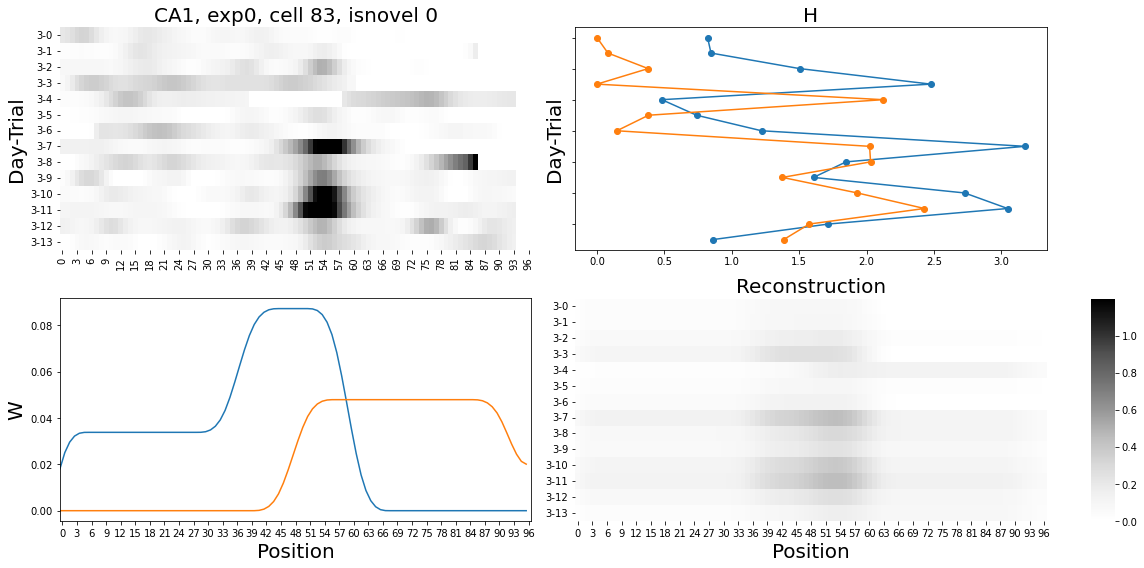

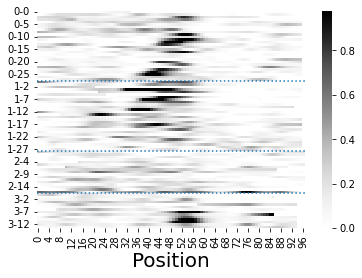

In [145]:
reload(unmf)
dosave = False
fig=unmf.plot_ratemap_and_wh(X_df_field,W_hat_ma,H_hat_ma,X_hat=X_hat,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)


if dosave:
    for fmt in ['svg','png']:
        fig_fn = f'good_ex_{region}_exp{exp}_uid{uid}_isnovel{isnovel}_day{get_field_day}_unmf.{fmt}'
        fig_fn_full=os.path.join(figdir,fig_fn)
        fig.savefig(fig_fn_full,bbox_inches='tight')
fig,ax=ph.heatmap(X_df_.T)
fig,ax=ph.plot_day_on_heatmap(X_df_.T,ax=ax,fig=fig)
if dosave:
    for fmt in ['svg','png']:
        fig_fn = f'good_ex_{region}_exp{exp}_uid{uid}_isnovel{isnovel}_allday.{fmt}'
        fig_fn_full=os.path.join(figdir,fig_fn)
        fig.savefig(fig_fn_full,bbox_inches='tight')


In [ ]:
uid = uid+1

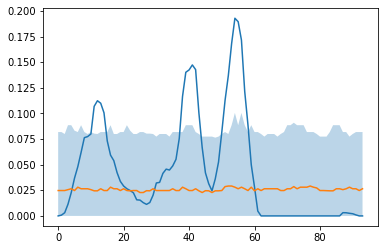

In [75]:
fig,ax=plt.subplots()
ax.plot(xs,X_df_field_avg)
ax.plot(xs,X_v_avg_shuffle_mean)
ax.fill_between(xs,X_v_avg_shuffle_up,X_v_avg_shuffle_low,alpha=0.3)



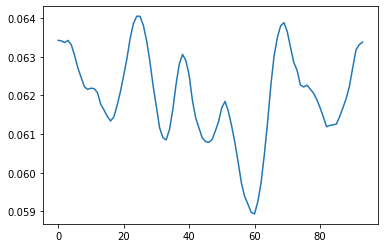

In [51]:
plt.plot(X_v_shuffle.mean(axis=2).mean(axis=0))

In [45]:
X_v_shuffle.shape

(100, 94, 14)

In [ ]:
# create shuffle distribution

In [31]:
X_df_field

3                                                              \
          0         1         2         3         4         5         6    
0   0.000000  0.000000  0.045460  0.027292  0.000000  0.066674  0.000000   
1   0.000000  0.000416  0.045460  0.027281  0.000000  0.071138  0.000000   
2   0.000000  0.003988  0.045459  0.028440  0.000000  0.077894  0.000000   
3   0.000000  0.011315  0.045458  0.033112  0.000000  0.087627  0.000000   
4   0.017079  0.021158  0.045454  0.044392  0.000000  0.101876  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
92  0.000000  0.000000  0.000000  0.000000  0.011887  0.012531  0.000675   
93  0.000000  0.000000  0.000000  0.000000  0.013345  0.020986  0.000000   
94       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
95       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
96       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

                                                                          
          7         8         9         10        11        12        13  
0   0.000000  0.001023  0.000000  0.000000  0.000000  0.009627  0.023190  
1   0.003118  0.001126  0.000000  0.000000  0.000000  0.007813  0.019128  
2   0.011204  0.002276  0.000000  0.000000  0.001112  0.004202  0.014468  
3   0.019410  0.005839  0.020266  0.000000  0.011507  0.000038  0.013597  
4   0.028208  0.012872  0.046815  0.027859  0.024498  0.000000  0.018848  
..       ...       ...       ...       ...       ...       ...       ...  
92  0.000000  0.000000  0.009630  0.023225  0.002439  0.000000  0.000000  
93  0.000000  0.000000  0.011044  0.018387  0.002792  0.000000  0.000000  
94       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
95       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
96       NaN       NaN       NaN       NaN       NaN       NaN       NaN  

[97 rows x 14 columns]

In [23]:
fr_map_avg = X_df_field.median(axis=1).dropna()

In [28]:
xs=np.array(fr_map_avg.index)
vals=fr_map_avg.values

In [21]:
import mode_cluster as mc
from mode_cluster import merge_peaks_and_troughs

In [27]:
pdf_peaks

Int64Index([12, 33, 41, 54, 87], dtype='int64')

In [29]:

pdf_peaks = xs[scipy.signal.find_peaks(vals)[0]]
pdf_troughs = xs[scipy.signal.find_peaks(-vals)[0]]
# if (self.peak_dist_thresh is not None) and (self.peak_dist_thresh < 100):
pdf_troughs = merge_peaks_and_troughs(pdf_peaks,pdf_troughs,peak_dist_thresh=10)[-1]

In [30]:
pdf_troughs

array([27., 47., 74.])

<Axes: >

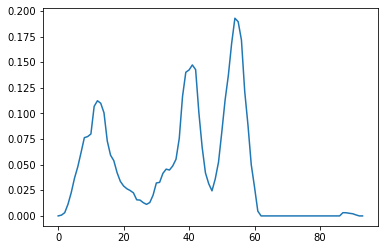

In [18]:
fr_map_avg.plot()

In [12]:
X_df_field

3                                                              \
          0         1         2         3         4         5         6    
0   0.000000  0.000000  0.045460  0.027292  0.000000  0.066674  0.000000   
1   0.000000  0.000416  0.045460  0.027281  0.000000  0.071138  0.000000   
2   0.000000  0.003988  0.045459  0.028440  0.000000  0.077894  0.000000   
3   0.000000  0.011315  0.045458  0.033112  0.000000  0.087627  0.000000   
4   0.017079  0.021158  0.045454  0.044392  0.000000  0.101876  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
92  0.000000  0.000000  0.000000  0.000000  0.011887  0.012531  0.000675   
93  0.000000  0.000000  0.000000  0.000000  0.013345  0.020986  0.000000   
94       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
95       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
96       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

                                                                          
          7         8         9         10        11        12        13  
0   0.000000  0.001023  0.000000  0.000000  0.000000  0.009627  0.023190  
1   0.003118  0.001126  0.000000  0.000000  0.000000  0.007813  0.019128  
2   0.011204  0.002276  0.000000  0.000000  0.001112  0.004202  0.014468  
3   0.019410  0.005839  0.020266  0.000000  0.011507  0.000038  0.013597  
4   0.028208  0.012872  0.046815  0.027859  0.024498  0.000000  0.018848  
..       ...       ...       ...       ...       ...       ...       ...  
92  0.000000  0.000000  0.009630  0.023225  0.002439  0.000000  0.000000  
93  0.000000  0.000000  0.011044  0.018387  0.002792  0.000000  0.000000  
94       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
95       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
96       NaN       NaN       NaN       NaN       NaN       NaN       NaN  

[97 rows x 14 columns]